# Legal Judgement Predictor - A classification task on BERT embeddings

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import seaborn as sns

path_to_datasets = 'embeddings_datasets/legal-bert-base-uncased/'

## Dataset

In [2]:
from src.echrdataset import ECHRDataset
from src.utils import create_dataset, load_dataset

#create_dataset(path_to_datasets)

train_dataset, test_dataset = load_dataset(path_to_datasets)

8480


## Data Understanding

(8480, 768)


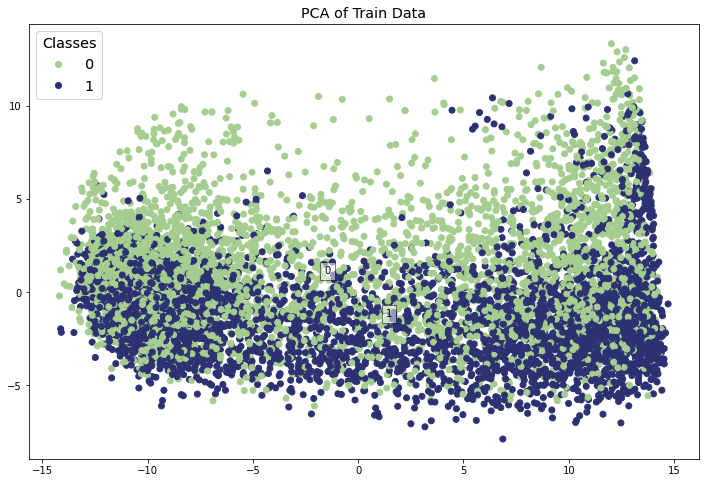

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np

scaler = StandardScaler()
first_chunk_train = np.array([x[0].numpy() for x in train_dataset.data])
first_chunk_test = np.array([x[0].numpy() for x in test_dataset.data])

print(first_chunk_train.shape)

pca = PCA(n_components=2)
xpca = pca.fit_transform(first_chunk_train)

fig = plt.figure(figsize=(12, 8))

# Scatter plot
scatter = plt.scatter(xpca[:, 0], xpca[:, 1], c=train_dataset.labels, cmap='crest')

# Get legend handles and labels
legend1 = plt.legend(*scatter.legend_elements(), title="Classes", fontsize = 'x-large', title_fontsize = 'x-large')

# Add legend to the plot
plt.gca().add_artist(legend1)
# Get unique class labels
unique_labels = np.unique(train_dataset.labels)
# Add custom labels for class 0 and class 1
for label in unique_labels:
    plt.text(xpca[train_dataset.labels == label, 0].mean(), xpca[train_dataset.labels == label, 1].mean(), str(label),
             horizontalalignment='center',
             verticalalignment='center', 
             bbox=dict(facecolor='white', alpha=0.5))

plt.title('PCA of Train Data', fontsize='x-large')

plt.show()

### Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(first_chunk_train, train_dataset.labels)
y_pred = rf_classifier.predict(first_chunk_test)
f1 = f1_score(test_dataset.labels, y_pred, average='weighted')
print(classification_report(test_dataset.labels, y_pred))
print("Random Forest F1:", f1)


              precision    recall  f1-score   support

           0       0.66      0.54      0.59      1024
           1       0.78      0.85      0.82      1974

    accuracy                           0.75      2998
   macro avg       0.72      0.70      0.70      2998
weighted avg       0.74      0.75      0.74      2998

Random Forest F1: 0.73960337479736


### SVM

In [5]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(first_chunk_train, train_dataset.labels)
y_pred_svm = svm_classifier.predict(first_chunk_test)
f1 = f1_score(test_dataset.labels, y_pred_svm, average='weighted')
print(classification_report(test_dataset.labels, y_pred_svm))
print("SVM F1:", f1)

              precision    recall  f1-score   support

           0       0.77      0.59      0.67      1024
           1       0.81      0.91      0.86      1974

    accuracy                           0.80      2998
   macro avg       0.79      0.75      0.76      2998
weighted avg       0.80      0.80      0.79      2998

SVM F1: 0.7938613853836507


<AxesSubplot:>

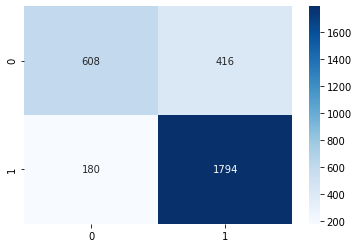

In [6]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dataset.labels, y_pred_svm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')


### MLP

In [7]:
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(hidden_layer_sizes=(16,), max_iter=200, learning_rate='adaptive', random_state=42)
mlp_classifier.fit(first_chunk_train, train_dataset.labels)
y_pred_mlp = mlp_classifier.predict(first_chunk_test)
f1 = f1_score(test_dataset.labels, y_pred_mlp, average='weighted')
print(classification_report(test_dataset.labels, y_pred_mlp))
print("MLP F1:", f1)

              precision    recall  f1-score   support

           0       0.80      0.54      0.65      1024
           1       0.80      0.93      0.86      1974

    accuracy                           0.80      2998
   macro avg       0.80      0.74      0.75      2998
weighted avg       0.80      0.80      0.79      2998

MLP F1: 0.787049658982523


/usr/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## AttentionMLP Model

In [16]:
from src.utils import get_device
device = get_device()

train_dataset.data = train_dataset.data.to(device)
train_dataset.labels = train_dataset.labels.to(device)
train_dataset.attention_mask = train_dataset.attention_mask.to(device)

test_dataset.data = test_dataset.data.to(device)
test_dataset.labels = test_dataset.labels.to(device)
test_dataset.attention_mask = test_dataset.attention_mask.to(device)

train_dataset.data.device

Running on GPU


device(type='cuda', index=1)

In [9]:
from src.attentionmlp import AttentionMLP
model = AttentionMLP(768, [768,16])
model = model.to(device)
results = model.k_fold ( 
                  criterion=nn.BCELoss(), 
                  train_dataset=train_dataset, 
                  lr=0.0001,
                  weight_decay=0.001,
                  k_folds=4, 
                  epochs=50, 
                  batch_size=64 )

Fold 1/4
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [00:55<00:00,  1.11s/epoch, Train Loss=0.329, Val Loss=0.337, Val Acc=0.862, Val F1=0.861]


Fold 2/4
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [00:55<00:00,  1.11s/epoch, Train Loss=0.324, Val Loss=0.366, Val Acc=0.832, Val F1=0.831]


Fold 3/4
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [00:56<00:00,  1.12s/epoch, Train Loss=0.314, Val Loss=0.386, Val Acc=0.841, Val F1=0.838]


Fold 4/4
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=768, out_features=768, bias=False)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [00:56<00:00,  1.13s/epoch, Train Loss=0.308, Val Loss=0.337, Val Acc=0.851, Val F1=0.851]


In [10]:
# print mean val loss and acc over fold 
loss = 0
acc = 0
f1 = 0
for key,value in results.items():
    loss += value['result']['best_val_loss']
    acc += value['result']['best_val_acc']
    f1 += value['result']['best_val_f1']

print('avg val loss: ', loss/len(results))
print('avg val acc: ', acc/len(results))
print('avg val f1: ', f1/len(results))

avg val loss:  0.3369407851029845
avg val acc:  0.8501179245283019
avg val f1:  0.8492106765889096


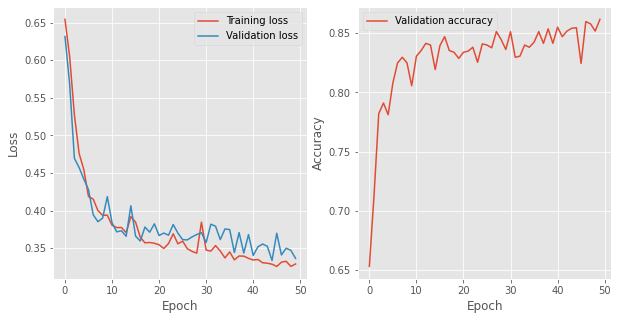

In [11]:
fold = 1
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(results[fold]['stats']['train_losses'], label='Training loss')
ax[0].plot(results[fold]['stats']['val_losses'], label='Validation loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(results[fold]['stats']['val_accs'], label='Validation accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()

## RnnMLP Model

In [12]:
from src.rnnmlp import RnnMLP
model = RnnMLP(768, 768, 2, 16, 1, dropout=0.1)
model = model.to(device)
results2 = model.k_fold( 
            criterion=nn.BCELoss(), 
            train_dataset=train_dataset, 
            lr=0.001, 
            weight_decay=1e-4, 
            k_folds=4, 
            epochs=50, 
            batch_size=128)

Fold 1/4
Reset trainable parameters of layer = LSTM(768, 768, num_layers=2, batch_first=True, dropout=0.1)
Reset trainable parameters of layer = Linear(in_features=768, out_features=16, bias=True)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [01:44<00:00,  2.10s/epoch, Train Loss=0.31, Val Loss=0.317, Val Acc=0.857, Val F1=0.855] 


Fold 2/4
Reset trainable parameters of layer = LSTM(768, 768, num_layers=2, batch_first=True, dropout=0.1)
Reset trainable parameters of layer = Linear(in_features=768, out_features=16, bias=True)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [01:45<00:00,  2.11s/epoch, Train Loss=0.307, Val Loss=0.358, Val Acc=0.842, Val F1=0.841]


Fold 3/4
Reset trainable parameters of layer = LSTM(768, 768, num_layers=2, batch_first=True, dropout=0.1)
Reset trainable parameters of layer = Linear(in_features=768, out_features=16, bias=True)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [01:44<00:00,  2.10s/epoch, Train Loss=0.289, Val Loss=0.355, Val Acc=0.845, Val F1=0.845]


Fold 4/4
Reset trainable parameters of layer = LSTM(768, 768, num_layers=2, batch_first=True, dropout=0.1)
Reset trainable parameters of layer = Linear(in_features=768, out_features=16, bias=True)
Reset trainable parameters of layer = Linear(in_features=16, out_features=1, bias=True)


Epochs: 100%|██████████| 50/50 [01:44<00:00,  2.10s/epoch, Train Loss=0.295, Val Loss=0.349, Val Acc=0.855, Val F1=0.854]


In [13]:
# print mean val loss and acc over fold 
loss = 0
acc = 0
f1 = 0
for key,value in results2.items():
    loss += value['result']['best_val_loss']
    acc += value['result']['best_val_acc']
    f1 += value['result']['best_val_f1']

print('avg val loss: ', loss/len(results))
print('avg val acc: ', acc/len(results))
print('avg val f1: ', f1/len(results))

avg val loss:  0.3200835482600857
avg val acc:  0.8579009433962264
avg val f1:  0.8565135965893773


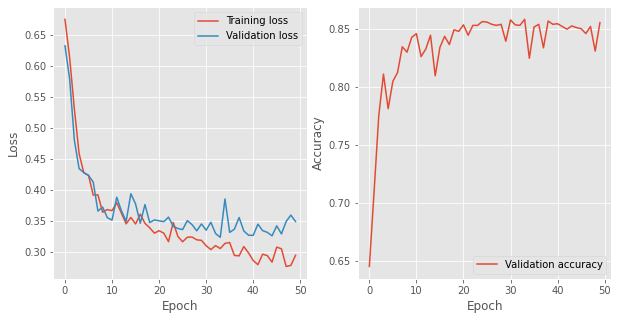

In [14]:
fold = 4

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(results2[fold]['stats']['train_losses'], label='Training loss')
ax[0].plot(results2[fold]['stats']['val_losses'], label='Validation loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(results2[fold]['stats']['val_accs'], label='Validation accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
plt.show()

## Test the best models

### AttentionMLP

In [17]:
from src.attentionmlp import AttentionMLP
model = AttentionMLP(768, [768,16])
model = model.to(device)
best_model, loss, acc, f1 = model.train_loop( 
                criterion=nn.BCELoss(),
                train_dataset=train_dataset,
                lr=0.0001,
                weight_decay=0.001,
                epochs=50,
                batch_size=64
                )

Epochs:   0%|          | 0/50 [00:00<?, ?epoch/s]

Epochs: 100%|██████████| 50/50 [01:00<00:00,  1.21s/epoch, Train Loss=0.327, Val Loss=0.38, Val Acc=0.83, Val F1=0.827]  


In [19]:
torch.save(best_model, 'models/attention-mlp.pt')

              precision    recall  f1-score   support

           0       0.83      0.52      0.64      1024
           1       0.79      0.94      0.86      1974

    accuracy                           0.80      2998
   macro avg       0.81      0.73      0.75      2998
weighted avg       0.80      0.80      0.78      2998

Test Accuracy: 0.7978652434956638
Test F1: 0.7835008835352554


<AxesSubplot:>

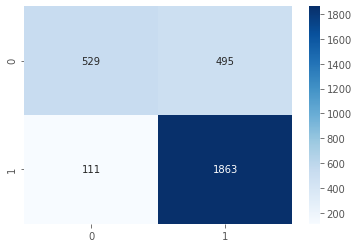

In [20]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
best_model = AttentionMLP(768, [768,16])
best_model.load_state_dict(torch.load('models/attention-mlp.pt'))
best_model = best_model.to(device)

best_model.eval()
with torch.no_grad():
    predictions = []
    labels_topredict = []
    for inputs, att_masks, labels in test_loader:
        outputs = best_model(inputs, att_masks)
        predictions.append(torch.round(outputs).to('cpu'))
        labels_topredict.append(labels.to('cpu'))

    predictions = torch.cat(predictions).numpy()
    labels_topredict = torch.cat(labels_topredict).numpy()
    test_acc = accuracy_score(labels_topredict, predictions)
    test_f1 = f1_score(labels_topredict, predictions, average='weighted')

print(classification_report(labels_topredict, predictions))
print(f"Test Accuracy: {test_acc}")
print(f"Test F1: {test_f1}")

cm = confusion_matrix(labels_topredict, predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

### RnnMLP

In [21]:
from src.rnnmlp import RnnMLP
model = RnnMLP(768, 768, 2, 16, 1, dropout=0.1)
model = model.to(device)
best_model, loss, acc, f1 = model.train_loop( 
            criterion=nn.BCELoss(), 
            train_dataset=train_dataset, 
            lr=0.001, 
            weight_decay=1e-4,  
            epochs=50, 
            batch_size=128)

Epochs: 100%|██████████| 50/50 [01:53<00:00,  2.27s/epoch, Train Loss=0.281, Val Loss=0.367, Val Acc=0.829, Val F1=0.827]


In [27]:
loss,acc,f1

(0.35283529332705904, 0.8384433962264151, 0.8366026469344504)

In [22]:
torch.save(best_model, 'models/rnn-mlp.pt')

              precision    recall  f1-score   support

           0       0.58      0.52      0.55      1024
           1       0.76      0.81      0.79      1974

    accuracy                           0.71      2998
   macro avg       0.67      0.66      0.67      2998
weighted avg       0.70      0.71      0.71      2998

Test Accuracy: 0.709472981987992
Test F1: 0.7052098756300567


<AxesSubplot:>

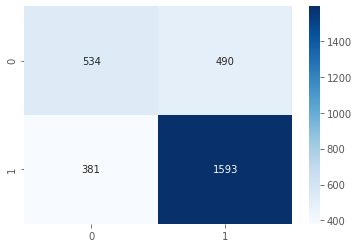

In [26]:
from torch.utils.data import DataLoader

test_dataset.attention_mask = train_dataset.attention_mask.to('cpu')

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
best_model = RnnMLP(768, 768, 2, 16, 1, dropout=0.1)
best_model.load_state_dict(torch.load('models/rnn-mlp.pt'))
best_model = best_model.to(device)

best_model.eval()
with torch.no_grad():
    predictions = []
    labels_topredict = []
    for inputs, att_masks, labels in test_loader:
        lengths = att_masks.sum(1)
        outputs = best_model(inputs, lengths)
        predictions.append(torch.round(outputs).to('cpu'))
        labels_topredict.append(labels.to('cpu'))

    predictions = torch.cat(predictions).numpy()
    labels_topredict = torch.cat(labels_topredict).numpy()
    test_acc = accuracy_score(labels_topredict, predictions)
    test_f1 = f1_score(labels_topredict, predictions, average='weighted')

print(classification_report(labels_topredict, predictions))
print(f"Test Accuracy: {test_acc}")
print(f"Test F1: {test_f1}")

cm = confusion_matrix(labels_topredict, predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')